In [13]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
df: DataFrame = pd.read_csv('data/moscow_apartment_listings.csv')
df.head()

,price,repair,year_built_empty,house_age,closest_subway,dist_to_subway,sg,lat,lon,subway_dist_to_center,...,subway_offers,address_offers,rooms,footage,floor,max_floor,first_floor,last_floor,AO,hm
0,8000000,3,0,42,59,960,0.0,55.609009,37.734632,17166,...,5,1.0,1,39.4,11,12,0,0,UAO,panel
1,7200000,2,0,43,59,802,0.0,55.608760,37.741936,17166,...,9,1.0,1,35.6,2,9,0,0,UAO,panel
2,10300000,2,0,43,59,638,0.0,55.610207,37.742495,17166,...,9,2.0,2,53.0,5,12,0,0,UAO,panel
3,8500000,2,0,43,59,929,0.0,55.624017,37.740373,17166,...,5,1.0,2,44.1,8,9,0,0,UAO,panel
4,9000000,2,0,43,59,785,0.0,55.609107,37.740430,17166,...,5,1.0,2,44.2,6,9,0,0,UAO,panel


## Описательный анализ данных:
Мы рассчитаем основные статистические показатели (среднее, медиану, стандартное отклонение и т.д.) для каждого числового столбца в нашем датасете. Это поможет нам лучше понять распределение и характеристики данных.

In [15]:
def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.2f%s' % (num, ['', ' тыс.', ' мил.'][magnitude])

df_normal: DataFrame = df[['price', 'repair', 'house_age', 'dist_to_subway', 'footage', 'floor', 'rooms']]
df2: DataFrame = df_normal.describe()
for frame in df2:
    df2[frame] = df2[frame].apply(human_format)

df2

,price,repair,house_age,dist_to_subway,footage,floor,rooms
count,12.18 тыс.,12.18 тыс.,12.18 тыс.,12.18 тыс.,12.18 тыс.,12.18 тыс.,12.18 тыс.
mean,10.87 мил.,2.27,36.36,928.35,46.15,6.87,1.60
std,3.04 мил.,0.79,21.41,532.44,10.54,5.31,0.49
min,4.90 мил.,1.00,0.00,11.00,30.10,1.00,1.00
25%,8.50 мил.,2.00,17.00,548.00,38.00,3.00,1.00
50%,10.20 мил.,2.00,42.00,820.00,44.50,5.00,2.00
75%,12.70 мил.,3.00,54.00,1.18 тыс.,53.40,9.00,2.00
max,20.00 мил.,4.00,130.00,2.99 тыс.,89.90,38.00,2.00


### Вывод:
    Цена (price): Средняя цена квартиры составляет примерно 10.87 миллиона рублей, со стандартным отклонением 3.04 миллиона рублей. Минимальная цена - 4.9 миллиона рублей, максимальная - 20 миллионов рублей.

    Состояние ремонта (repair): Среднее значение состояния ремонта близко к 2, что указывает на то, что большинство квартир имеют среднее качество ремонта.

    Возраст дома (house_age): Средний возраст дома составляет около 36 лет, со стандартным отклонением в 21 год.

    Расстояние до метро (dist_to_subway): В среднем квартиры находятся на расстоянии около 928 метров от метро.

    Площадь квартир (footage): Средняя площадь квартиры составляет около 46 квадратных метров.

    Этаж (floor) и максимальное количество этажей (max_floor): Средний этаж, на котором расположена квартира, - это 7-й этаж, при этом в здании в среднем 13 этажей.

    Количество комнат (rooms): Большинство квартир имеют 1 или 2 комнаты.

# Визуализация распределения ключевых переменных

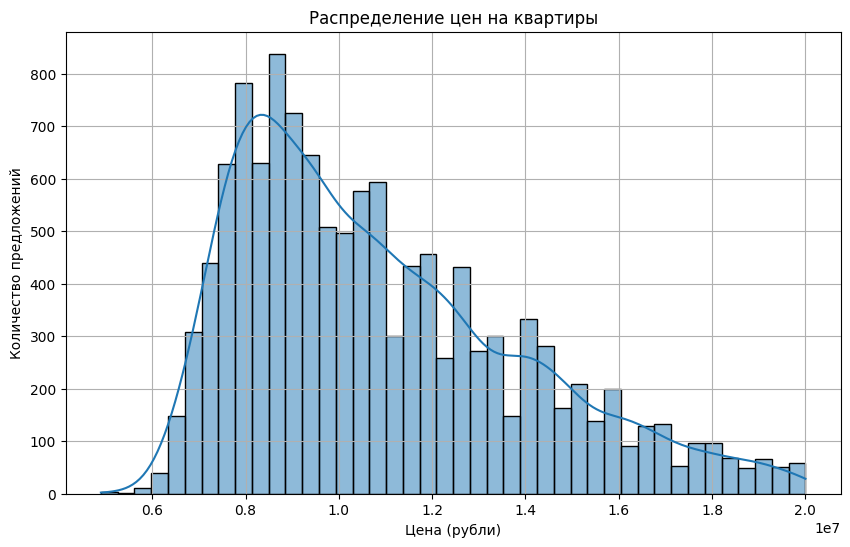

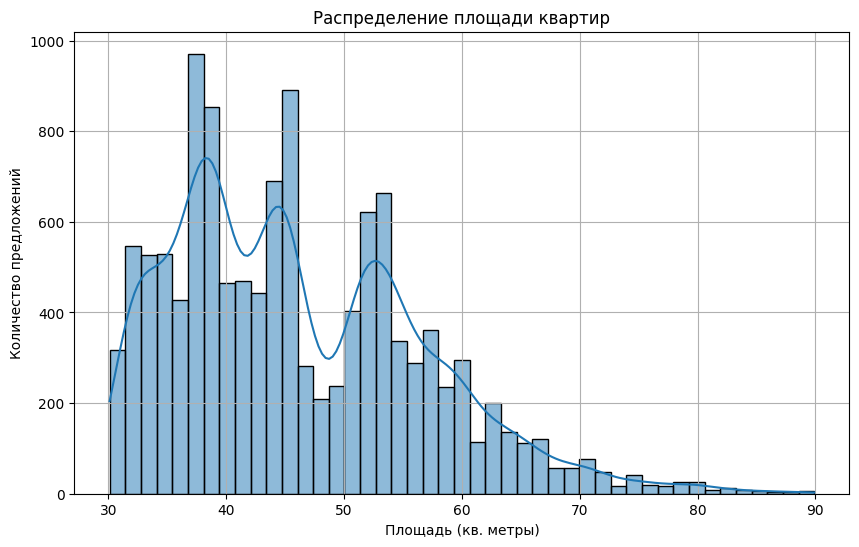

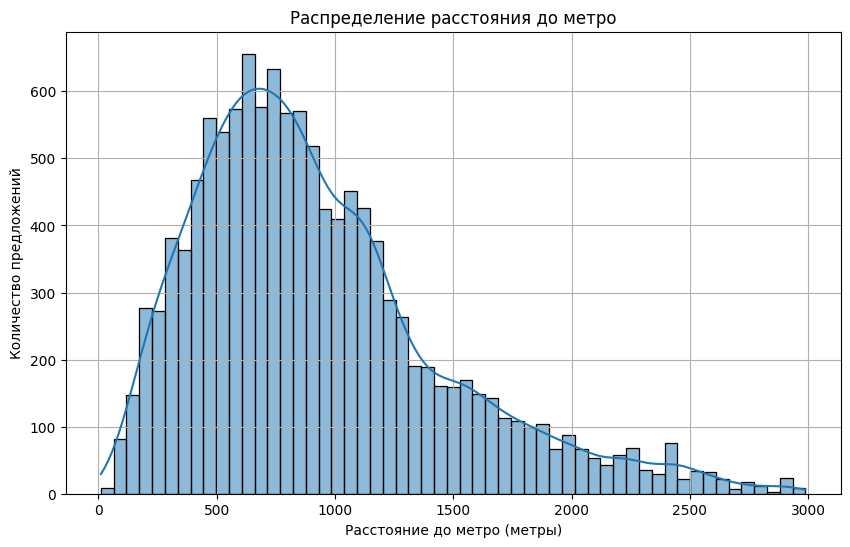

In [16]:
# Визуализация распределения ключевых переменных

# Гистограмма цен
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Распределение цен на квартиры')
plt.xlabel('Цена (рубли)')
plt.ylabel('Количество предложений')
plt.grid(True)
plt.show()

# Гистограмма площади квартир
plt.figure(figsize=(10, 6))
sns.histplot(df['footage'], kde=True)
plt.title('Распределение площади квартир')
plt.xlabel('Площадь (кв. метры)')
plt.ylabel('Количество предложений')
plt.grid(True)
plt.show()

# Гистограмма расстояния до метро
plt.figure(figsize=(10, 6))
sns.histplot(df['dist_to_subway'], kde=True)
plt.title('Распределение расстояния до метро')
plt.xlabel('Расстояние до метро (метры)')
plt.ylabel('Количество предложений')
plt.grid(True)
plt.show()


## Проведем корреляционный анализ

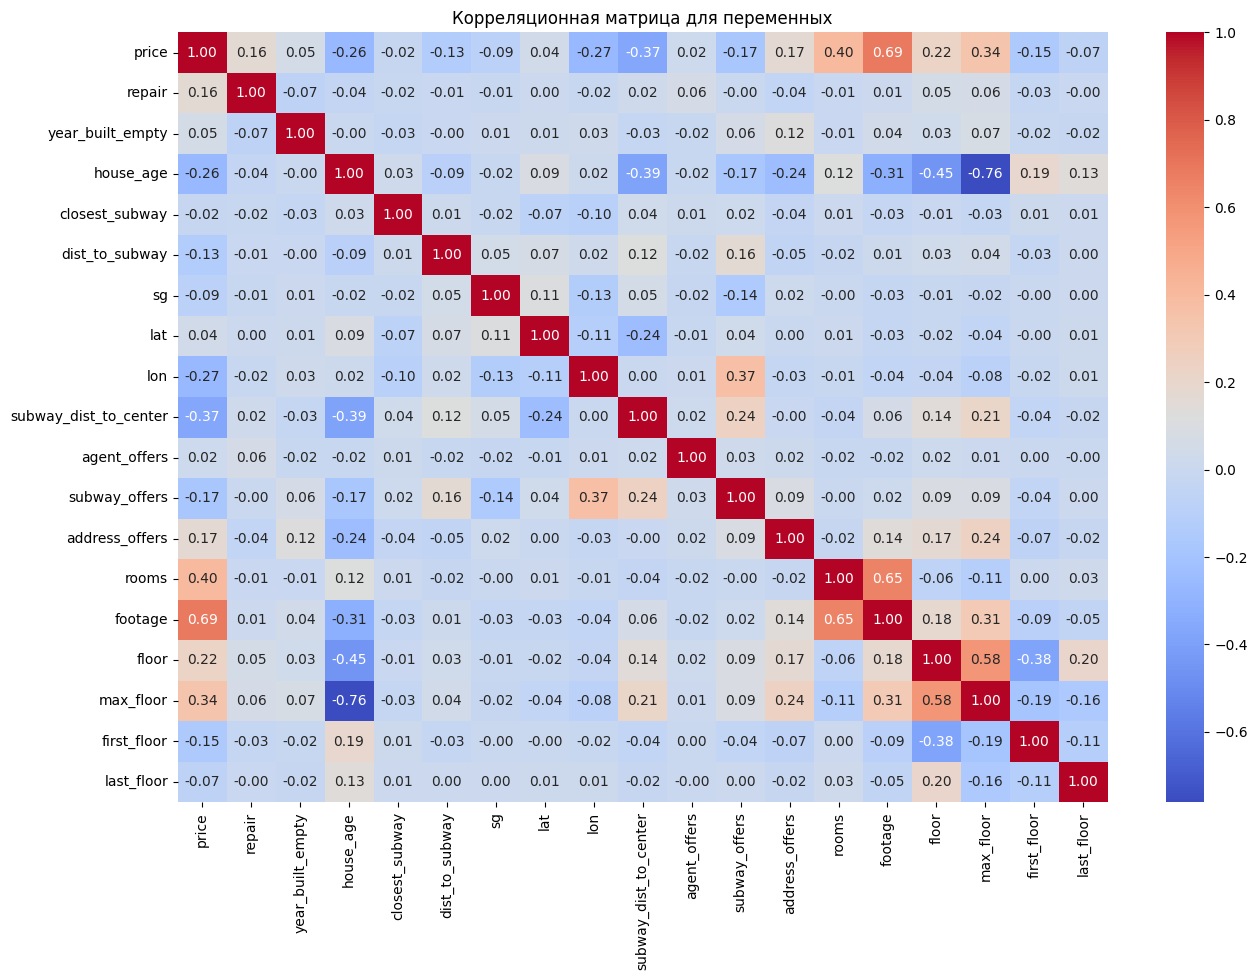

In [33]:
correlation_df: DataFrame = df.drop(['AO', 'hm', 'h3'], axis=1)

# Вычисление коэффициентов корреляции
correlation_matrix:float = correlation_df.corr()

# Создание тепловой карты для визуализации коэффициентов корреляции
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица для переменных')
plt.show()

На тепловой карте корреляционной матрицы представлены коэффициенты корреляции Пирсона между различными переменными в нашем датасете. Вот некоторые ключевые наблюдения:

    Корреляция с ценой (price):
        Площадь квартиры (footage) имеет сильную положительную корреляцию с ценой. Это означает, что с увеличением площади квартиры, как правило, увеличивается и её цена.
        Количество комнат (rooms) также положительно коррелирует с ценой, что логично, так как больше комнат обычно означает большую площадь.
        Расстояние до метро (dist_to_subway) имеет отрицательную корреляцию с ценой, что может указывать на то, что квартиры, расположенные ближе к метро, стоят дороже.

    Другие интересные корреляции:
        Возраст дома (house_age) имеет отрицательную корреляцию с ценой, что может говорить о том, что более новые квартиры стоят дороже.
        Этаж (floor) и максимальный этаж в здании (max_floor) имеют положительную корреляцию, что может отражать предпочтения покупателей квартир на более высоких этажах.

## Ящик с усами

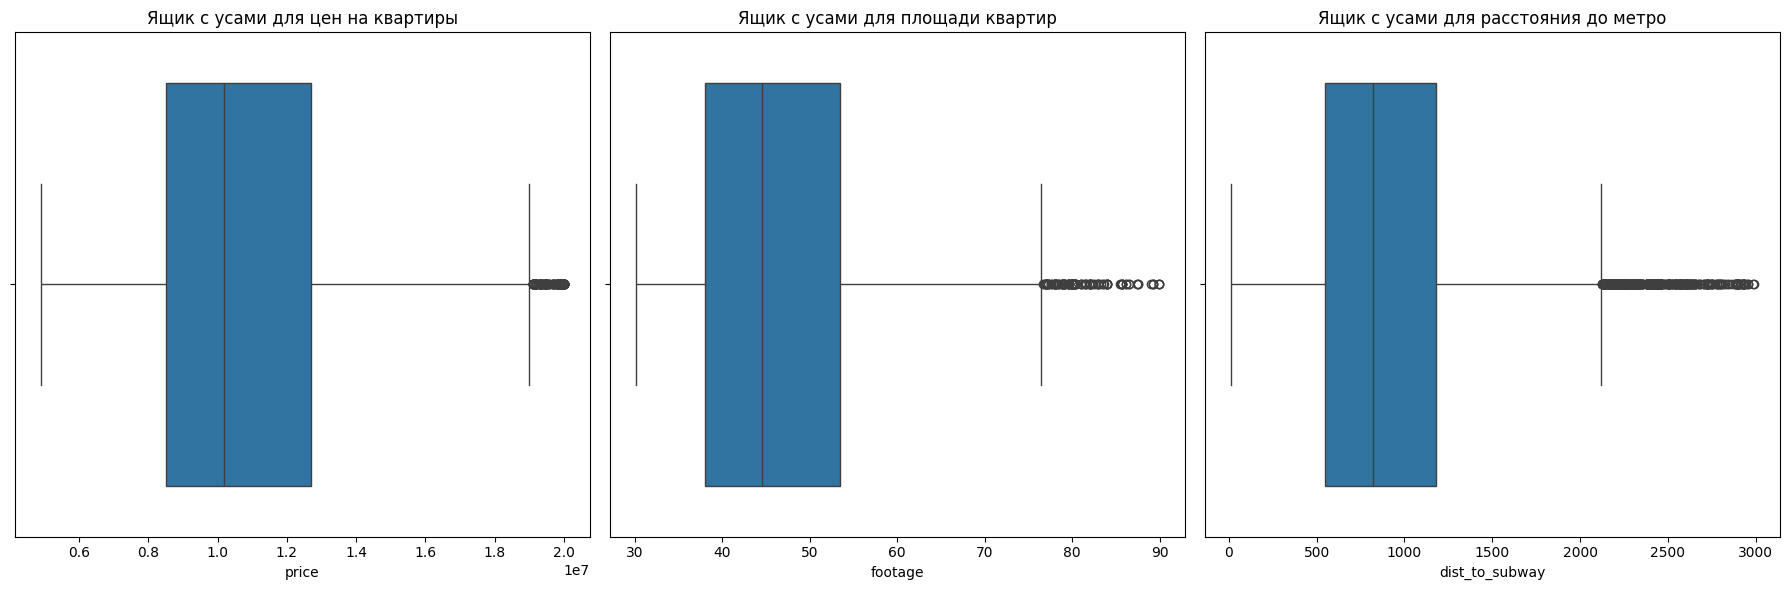

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Ящик с усами для цены
sns.boxplot(ax=axes[0], x=df['price'])
axes[0].set_title('Ящик с усами для цен на квартиры')

# Ящик с усами для площади квартир
sns.boxplot(ax=axes[1], x=df['footage'])
axes[1].set_title('Ящик с усами для площади квартир')

# Ящик с усами для расстояния до метро
sns.boxplot(ax=axes[2], x=df['dist_to_subway'])
axes[2].set_title('Ящик с усами для расстояния до метро')

plt.tight_layout()
plt.show()

Ящик с усами для цен на квартиры

    График показывает, что большинство цен находятся в пределах определенного диапазона, но также существует ряд выбросов с очень высокой стоимостью. Эти выбросы могут быть связаны с квартирами особо высокого класса или с уникальными характеристиками.

Ящик с усами для площади квартир

    Площадь квартир также имеет несколько выбросов, особенно для очень больших квартир. Это могут быть квартиры с нестандартной планировкой или роскошные апартаменты.

Ящик с усами для расстояния до метро

    Распределение расстояния до метро более компактное, но также содержит выбросы, относящиеся к квартирам, расположенным далеко от станций метро.

## Обработка выбросов

In [ ]:
#